In [1]:
import sys,os
from pathlib import Path

def add_dependencies():
    add_path = lambda path: sys.path.append(str(path))
    root_folder = Path(os.getcwd()).parent
    cryoem_folder = Path(root_folder, 'cryoem')
    cython_folder = Path(root_folder,'cryoem-cython-pyx')

    add_path(root_folder)
    add_path(cryoem_folder)
    add_path(Path(cryoem_folder,'util'))
    add_path(Path(cython_folder,'sincint'))
    add_path(Path(cython_folder,'sparsemul'))

add_dependencies()

In [2]:
from typing import List, Tuple

from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import starfile
import pandas as pd

from cryoem.cryoio import mrc
from cryoem.cryoops import compute_premultiplier
from cryoem.density import real_to_fspace
from cryoem.snapshot import Snapshot
from cryoem.typing import Density

mpl.rcParams['figure.dpi'] = 300
plt.style.use(['dark_background'])

ERROR LOADING FFTW! USING NUMPY


In [3]:
def load_scatter_pattern(volume_data: str | Path) -> Tuple[Density, float]:
    '''Read the volume data, returns scatter wave and pixel size'''
    wave_3d,hdr = mrc.readMRC(volume_data, inc_header=True)

    box_size = int(wave_3d.shape[0])
    pixel_size = hdr['xlen']/hdr['nx']

    premult_1d = compute_premultiplier(box_size, Snapshot.projection_opts['kern'], Snapshot.projection_opts['kernsize']) 
    premult_3d = premult_1d[None,None] * premult_1d[None,:,None] * premult_1d[:,None,None]

    return real_to_fspace(premult_3d * wave_3d), pixel_size

def generate_snapshots(spectral_wave_3d: Density, pixel_size: float) -> List[Snapshot]:
    '''Create snapshot images + metadata from volume'''
    box_size = len(spectral_wave_3d)
    n_particles = 10
    embedding = Snapshot.embedding(box_size)

    snapshots: List[Snapshot] = []
    for _ in tqdm(range(n_particles)):
        snapshots.append(Snapshot(pixel_size=pixel_size).generate_images(spectral_wave_3d, box_size, embedding))

    return snapshots                 

In [4]:
spectral_wave_3d, pixel_size = load_scatter_pattern("../data/cav_3d.mrc")


In [5]:
from cryoem.geom import gencoords, gencoords_base

box_size = len(spectral_wave_3d)
grid_3d = gencoords(box_size,3)
ticks_3d = (np.linspace(-box_size//2,box_size//2,box_size),)*3
grid_2d = gencoords(box_size,2,0.95)

In [6]:
from cryoem.density import Lanczos3DInterpolator, RegularGridInterpolator

lin_interp = RegularGridInterpolator(ticks_3d, spectral_wave_3d)
lanc_interp = Lanczos3DInterpolator(grid_3d,spectral_wave_3d)

In [7]:
from cryoem.cryoem import random_unit_vector
from cryoem.typing import Projection

def random_hyperplane() -> Projection:
    X = random_unit_vector()
    xz_vec = random_unit_vector()
    Y = np.cross(xz_vec,X)
    if (Ny := np.linalg.norm(Y)) > 1e-10:
        return np.stack([X,Y/Ny],axis=-1)
    return random_hyperplane()

projection = random_hyperplane()
query_3d = grid_2d @ projection.T

  0%|          | 0/10 [00:00<?, ?it/s]/Users/jovdoors/Folding/forked/cryoem-data-simulation/.venv/lib/python3.12/site-packages/numpy/_core/_asarray.py:107: ComplexWarning: Casting complex values to real discards the imaginary part
  return asanyarray(a, dtype=dtype)
100%|██████████| 10/10 [01:06<00:00,  6.66s/it]


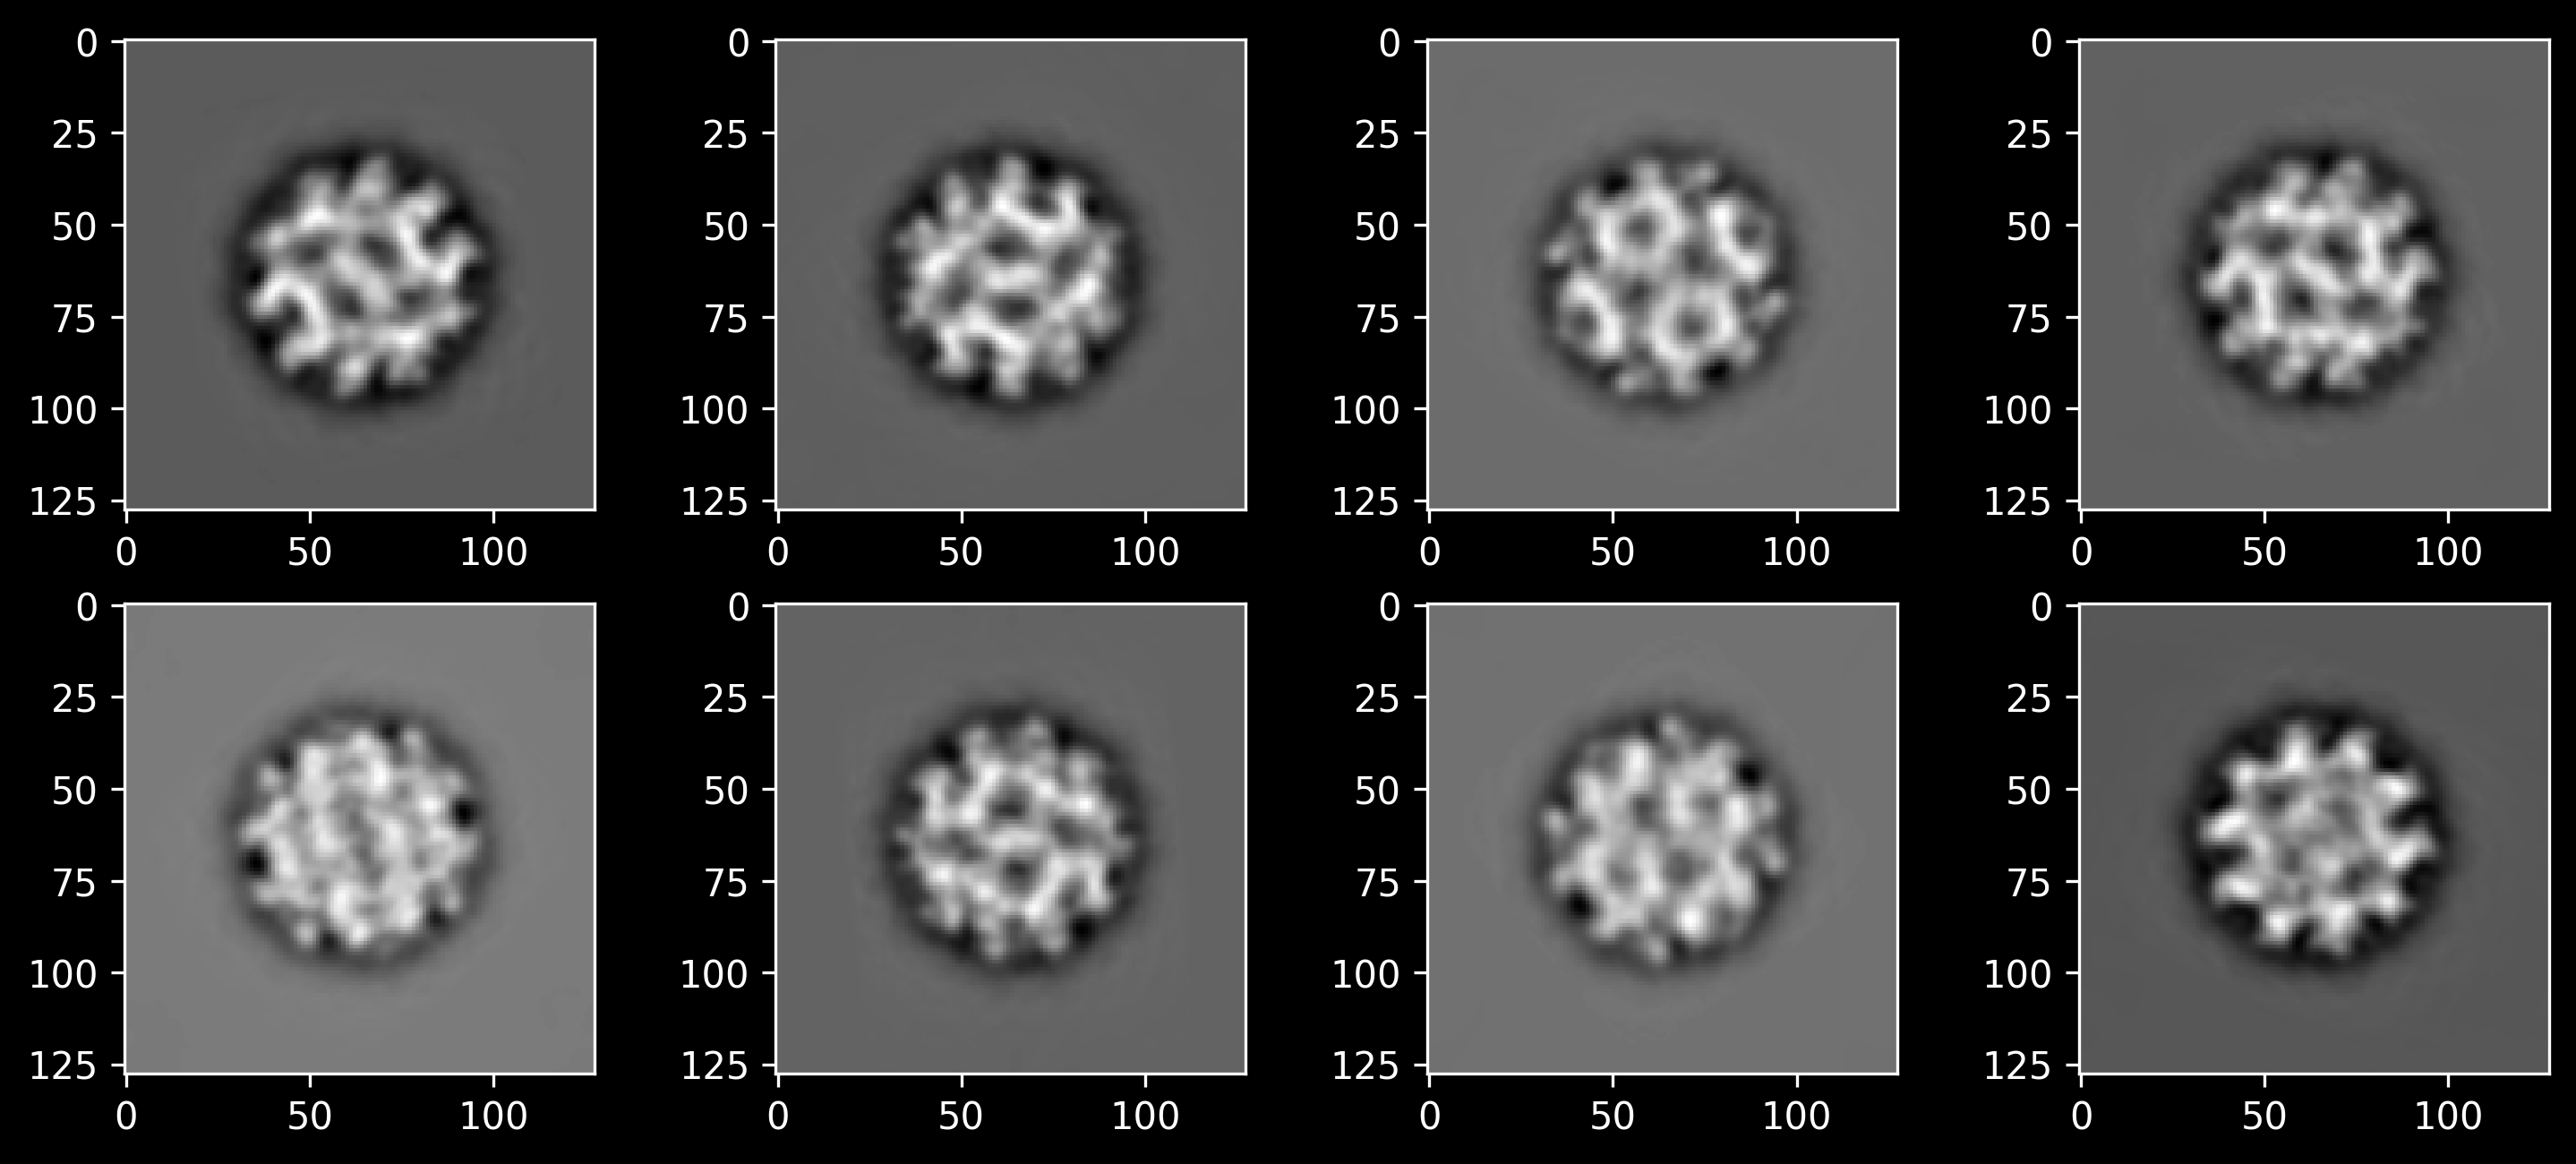

In [9]:
spectral_wave_3d, pixel_size = load_scatter_pattern("../data/cav_3d.mrc")
snapshots = generate_snapshots(spectral_wave_3d, pixel_size)

output_folder = Path('..','output')
output_folder.mkdir(exist_ok=True)

# Plot the first 8 images
fig,axes = plt.subplots(2,4,figsize=(12, 5))

for ax, snapshot in zip(axes.flatten(), snapshots):
    ax.imshow(snapshot.wave_2d, cmap='gray')
plt.savefig(Path(output_folder,'projections.png'))
plt.show()


In [10]:
# Write the particle stack
mrc.writeMRC(Path(output_folder,'simulated_particles.mrcs'), np.stack([s.wave_2d for s in snapshots],axis=-1), pixel_size)

In [11]:
# Write the starfile
def to_camel_case(text):
    return ''.join(word.capitalize() for word in text.split('_'))

star_path = Path(output_folder,'simulated_particles.star')
df = pd.DataFrame(snapshots)
df.columns = [f'rln{to_camel_case(col)} #{i}' for i,col in enumerate(df.columns,1)]
starfile.write(df, star_path)

df

,rlnAmpContrast #1,rlnPhi #2,rlnTheta #3,rlnPsi #4,rlnClassNumer #5,rlnAstigAngle #6,rlnDefocusA #7,rlnDefocusB #8,rlnPixelSize #9,rlnImageName #10,rlnMagnification #11,rlnOriginX #12,rlnOriginY #13,rlnPhaseShift #14,rlnSphericalAbberation #15,rlnVoltage #16
0,0.07,22.873802,101.830711,11.481312,1,25.307852,14777.284146,15173.350604,1.007812,1@/simulated_particles.mrcs,10000.0,0,0,0.0,2.7,300
1,0.07,-41.824240,76.126688,126.408221,1,152.598819,13309.929310,13179.280020,1.007812,2@/simulated_particles.mrcs,10000.0,0,0,0.0,2.7,300
2,0.07,55.839277,75.427882,60.712774,1,218.652871,13410.642860,13818.578199,1.007812,3@/simulated_particles.mrcs,10000.0,0,0,0.0,2.7,300
3,0.07,-28.261845,162.694174,353.776549,1,298.311310,14243.898868,14472.502042,1.007812,4@/simulated_particles.mrcs,10000.0,0,0,0.0,2.7,300
4,0.07,-74.499998,151.827398,57.886564,1,167.861515,13797.612771,13825.309840,1.007812,5@/simulated_particles.mrcs,10000.0,0,0,0.0,2.7,300
5,0.07,96.091888,38.418797,90.463114,1,72.731557,12733.123653,13232.215971,1.007812,6@/simulated_particles.mrcs,10000.0,0,0,0.0,2.7,300
6,0.07,-176.587608,96.616299,128.149640,1,121.828452,11083.074806,10885.417119,1.007812,7@/simulated_particles.mrcs,10000.0,0,0,0.0,2.7,300
7,0.07,100.023911,52.863904,150.672421,1,282.798125,19061.081408,18167.705024,1.007812,8@/simulated_particles.mrcs,10000.0,0,0,0.0,2.7,300
8,0.07,-168.438399,19.657097,256.175794,1,44.892147,15699.042593,15927.826584,1.007812,9@/simulated_particles.mrcs,10000.0,0,0,0.0,2.7,300
9,0.07,37.863330,154.495210,171.492674,1,39.225578,17729.634088,18038.531389,1.007812,10@/simulated_particles.mrcs,10000.0,0,0,0.0,2.7,300
